In [91]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

DataLoader

In [92]:
!ls /kaggle/input/isbi2017

/bin/bash: /home/user/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
ls: cannot access '/kaggle/input/isbi2017': No such file or directory


In [93]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import transforms,models
import torchvision.transforms.functional as TF
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import time
from torchvision.utils import make_grid
import torch.nn.functional as F
import sys
sys.path.append('DexiNed') 
from model import DexiNed
import warnings
warnings.filterwarnings("ignore")

In [94]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

In [95]:
x_train = ('skin lesion/trainx')
y_train = ('skin lesion/trainy')
x_valid = ('skin lesion/validationx')
y_valid = ('skin lesion/validationy')
x_test = ('skin lesion/testx')
y_test = ('skin lesion/testy')

In [96]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transforms
        self.image_filenames = os.listdir(image_dir)

    def transforms(self,image,mask):
        resized_img = cv2.resize(image,(256,256), interpolation=cv2.INTER_AREA)
        resized_mask = cv2.resize(mask, (256,256), interpolation=cv2.INTER_AREA)

        tensor_image = F.to_tensor(resized_img)
        tensor_mask = F.to_tensor(resized_mask)

        if np.random.rand() > 0.5:
            tensor_image = F.hflip(tensor_image)
            ternsor_mask = F.hflip(tensor_mask)
        if np.random.rand() > 0.5:
            tensor_image = F.vflip(tensor_image)
            tensor_mask = F.vflip(tensor_mask)

        if np.random.rand() > 0.5:
            tensor_image = F.rotate(tensor_image, angle=90)
            tensor_mask = F.rotate(tensor_mask, angle=90)

        if np.random.rand() > 0.5:
            tensor_image = F.center_crop(tensor_image, (256,256))
            tensor_mask = F.center_crop(tensor_mask, (256,256))
        return tensor_image, tensor_mask


    def __getitem__(self, index):
        image_filename = self.image_filenames[index]
        image_path = os.path.join(self.image_dir, image_filename)
        image = Image.open(image_path).convert('RGB')

        mask_filename = image_filename.replace("imgx", "imgy")
        mask_path = os.path.join(self.mask_dir, mask_filename)
        mask = Image.open(mask_path).convert('L')

        return image, mask

    def __len__(self):
        return len(self.image_filenames)

In [97]:
def custom_collate(batch):
    images = []
    masks = []
    for sample in batch:
        image = transforms.ToTensor()(sample[0])
        mask = transforms.ToTensor()(sample[1])
        images.append(image)
        masks.append(mask)
    return torch.stack(images), torch.stack(masks)

In [98]:
test_data=MyDataset(x_test,y_test,transform=transform)
train_data = MyDataset(x_train,y_train,transform=transform)
validation_data=MyDataset(x_valid,y_valid,transform=transform)

In [99]:
test_loader = DataLoader(test_data, batch_size=10, shuffle=True, collate_fn=custom_collate)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True, collate_fn=custom_collate)
validation_loader = DataLoader(validation_data, batch_size=10, shuffle=True, collate_fn=custom_collate)

In [100]:
batches_1 = len(validation_loader)
samples_1 = 10*batches_1
batches_2 = len(test_loader)
samples_2 = 10*batches_2

print("Number of samples in validation_loader:", samples_1)
print("Number of samples in test_loader:", samples_2)

Number of samples in validation_loader: 150
Number of samples in test_loader: 600


Data Visualisation

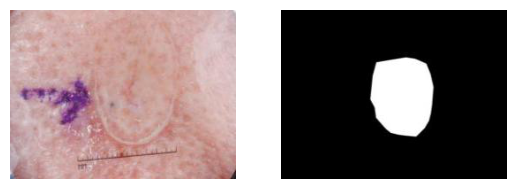

In [101]:
images, masks = next(iter(test_loader))
image = images[0]
mask = masks[0]
image = image.permute(1, 2, 0).numpy()
mask = mask.squeeze().numpy()
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[1].imshow(mask,cmap='gray')
axs[0].axis('off')
axs[1].axis('off')
plt.show()

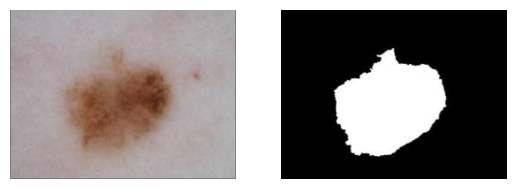

In [102]:
images, masks = next(iter(train_loader))
image = images[0]
mask = masks[0]
image = image.permute(1, 2, 0).numpy()
mask = mask.squeeze().numpy()
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[1].imshow(mask,cmap='gray')
axs[0].axis('off')
axs[1].axis('off')
plt.show()

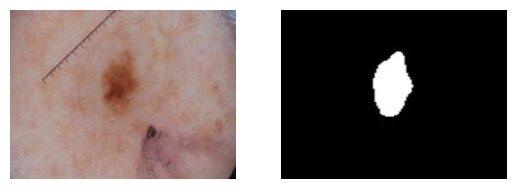

In [103]:
images, masks = next(iter(validation_loader))
image = images[0]
mask = masks[0]
image = image.permute(1, 2, 0).numpy()
mask = mask.squeeze().numpy()
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[1].imshow(mask,cmap='gray')
axs[0].axis('off')
axs[1].axis('off')
plt.show()

In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Model-1 : EOCNet

In [105]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    self.res=model.resnet50(pretrained=True)
    self.enc=nn.Sequential(self.res.conv1,self.res.bn1,self.res.relu,self.res.maxpool,self.res.layer1)

  def forward(self,x):
    commonInp=self.enc(x)
    oup1=self.res.layer2(commonInp)
    oup2=self.res.layer3(oup1)
    oup3=self.res.layer4(oup2)
    return oup1, oup2, oup3 

In [106]:
class EdgeDetect(nn.Module):
  def __init__(self):
    super(EdgeDetect,self).__init__()
    self.dex=DexiNed()

  def forward(self,x):
    oup=self.dex(x)[-1]
    return oup

In [107]:
class OmniScale(nn.Module):
  def __init__(self,inCh):
    super(OmniScale,self).__init__()
    self.conv1=nn.Conv2d(inCh,inCh,kernel_size=3,padding=1,groups=inCh)
    self.conv2=nn.Conv2d(inCh,inCh,kernel_size=5,padding=2,groups=inCh)
    self.conv3=nn.Conv2d(inCh,inCh,kernel_size=7,padding=3,groups=inCh)
    self.conv4=nn.Conv2d(inCh,inCh,kernel_size=9,padding=4,groups=inCh)

  def forward(self,x):
    o1=self.conv1(self.conv2(self.conv3(self.conv4(x))))
    o2=self.conv2(self.conv3(self.conv4(x)))
    o3=self.conv3(self.conv4(x))
    o4=self.conv4(x)
    return o1,o2,o3,o4

In [108]:
class EOCNet(nn.Module):
    def __init__(self):
        super(EOCNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=7, padding=3)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=64, kernel_size=1, padding=0)
        self.bn = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, padding=0)

        # self.encoder=Encoder()
        # self.edgeDetect=EdgeDetect()
        # self.omniScale=OmniScale(16+16+16)
    
    def forward(self, x):
        x1 = nn.functional.relu(self.conv1(x))
        x2 = nn.functional.relu(self.conv2(x1))
        x3 = nn.functional.relu(self.conv3(x2))
        x4 = nn.functional.relu(self.conv4(x3))

        # x_encoded = self.encoder(x)
        # x_edge = self.edge_detect(x)
        # x_omni = self.omni_scale(x)
        # x_concat = torch.cat((x1, x2, x3, x4, x_encoded, x_edge, x_omni), dim=1)

        x_concat = torch.cat((x1, x2, x3, x4), dim=1)
        x5 = nn.functional.relu(self.conv5(x_concat))
        x_bn = self.bn(x5)
        x6 = self.conv6(x_bn)
        y = torch.sigmoid(x6)
        return y

In [109]:
model_1 = EOCNet().to(device)

In [110]:
def evaluate(model, data_loader, device):
    criterion = nn.MSELoss()
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            acc = torch.sum(torch.round(outputs) == labels)
            val_acc += acc
    val_loss /= len(data_loader)
    val_acc = 100.0 * float(val_acc.item()) / (len(data_loader.dataset))
    return val_loss, val_acc

In [111]:
def train(model, train_loader, validation_loader, num_epochs, batch_size, optimizer, device):
    criterion = nn.MSELoss()
    train_losses = []
    train_accs = []
    val_accs = []
    val_losses = []
    time1 = []
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_acc = 0, 0
        print("\nEpoch: ", str(epoch + 1), "/", str(num_epochs))
        with tqdm(total=len(train_loader)) as pbar:
            for i, data in enumerate(train_loader):
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                acc = torch.sum(torch.round(outputs) == labels)
                train_acc += acc
                pbar.set_postfix(Loss='{0:.4f}'.format(loss.item()), Accuracy='{0:.4f}'.format(float(train_acc.item() / (batch_size * (i + 1)))))
                pbar.update(1)

        epoch_loss = train_loss / len(train_loader)
        epoch_acc = 100.0 * float(train_acc.item()) / (len(train_loader) * batch_size)
        val_loss, val_acc = evaluate(model, validation_loader, device)
        val_accs.append(val_acc)
        val_losses.append(val_loss)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        end_time = time.time()
        time2 = end_time - start_time
        time1.append(time2)
        print("Train Loss: {0:.4f}, Train Accuracy: {1:.2f}%, Valid Loss: {2:.4f}, Valid Accuracy: {3:.2f}%".format(epoch_loss, epoch_acc, val_loss, val_acc))
    return train_accs, train_losses, val_accs, val_losses

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EOCNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
train_accs_EOCNet, train_loss_EOCNet, valid_accs_EOCNet, valid_loss_EOCNet = train(model, train_loader,validation_loader, 25, 10, optimizer, device)



Epoch:  1 / 25


100%|██████████| 200/200 [00:14<00:00, 14.26it/s, Accuracy=32691.9840, Loss=0.1844]


Train Loss: 0.2036, Train Accuracy: 3269198.40%, Valid Loss: 0.2262, Valid Accuracy: 3140012.67%

Epoch:  2 / 25


100%|██████████| 200/200 [00:13<00:00, 14.57it/s, Accuracy=40530.3130, Loss=0.1187]


Train Loss: 0.1084, Train Accuracy: 4053031.30%, Valid Loss: 0.1009, Valid Accuracy: 4100910.00%

Epoch:  3 / 25


100%|██████████| 200/200 [00:13<00:00, 14.51it/s, Accuracy=40690.7370, Loss=0.0683]


Train Loss: 0.1028, Train Accuracy: 4069073.70%, Valid Loss: 0.0991, Valid Accuracy: 4113730.67%

Epoch:  4 / 25


100%|██████████| 200/200 [00:14<00:00, 14.25it/s, Accuracy=40868.4715, Loss=0.1129]


Train Loss: 0.0999, Train Accuracy: 4086847.15%, Valid Loss: 0.1028, Valid Accuracy: 4080146.00%

Epoch:  5 / 25


100%|██████████| 200/200 [00:14<00:00, 14.22it/s, Accuracy=40989.9595, Loss=0.1465]


Train Loss: 0.0987, Train Accuracy: 4098995.95%, Valid Loss: 0.1040, Valid Accuracy: 4065959.33%

Epoch:  6 / 25


100%|██████████| 200/200 [00:14<00:00, 13.82it/s, Accuracy=41064.0525, Loss=0.0373]


Train Loss: 0.0981, Train Accuracy: 4106405.25%, Valid Loss: 0.0970, Valid Accuracy: 4139844.00%

Epoch:  7 / 25


100%|██████████| 200/200 [00:14<00:00, 14.09it/s, Accuracy=41054.5160, Loss=0.0784]


Train Loss: 0.0975, Train Accuracy: 4105451.60%, Valid Loss: 0.0985, Valid Accuracy: 4101310.00%

Epoch:  8 / 25


100%|██████████| 200/200 [00:13<00:00, 14.47it/s, Accuracy=41033.7155, Loss=0.1376]


Train Loss: 0.0967, Train Accuracy: 4103371.55%, Valid Loss: 0.1160, Valid Accuracy: 3992782.00%

Epoch:  9 / 25


100%|██████████| 200/200 [00:13<00:00, 14.30it/s, Accuracy=41078.4605, Loss=0.0863]


Train Loss: 0.0967, Train Accuracy: 4107846.05%, Valid Loss: 0.1014, Valid Accuracy: 4076655.33%

Epoch:  10 / 25


100%|██████████| 200/200 [00:14<00:00, 14.09it/s, Accuracy=41094.0670, Loss=0.1784]


Train Loss: 0.0964, Train Accuracy: 4109406.70%, Valid Loss: 0.1015, Valid Accuracy: 4080784.67%

Epoch:  11 / 25


100%|██████████| 200/200 [00:14<00:00, 13.80it/s, Accuracy=41075.2710, Loss=0.1235]


Train Loss: 0.0965, Train Accuracy: 4107527.10%, Valid Loss: 0.0969, Valid Accuracy: 4115826.67%

Epoch:  12 / 25


100%|██████████| 200/200 [00:14<00:00, 13.90it/s, Accuracy=41085.5475, Loss=0.1186]


Train Loss: 0.0962, Train Accuracy: 4108554.75%, Valid Loss: 0.1043, Valid Accuracy: 4063445.33%

Epoch:  13 / 25


100%|██████████| 200/200 [00:14<00:00, 13.82it/s, Accuracy=41122.0395, Loss=0.0931]


Train Loss: 0.0956, Train Accuracy: 4112203.95%, Valid Loss: 0.1166, Valid Accuracy: 3982495.33%

Epoch:  14 / 25


100%|██████████| 200/200 [00:14<00:00, 13.95it/s, Accuracy=41137.4080, Loss=0.0959]


Train Loss: 0.0953, Train Accuracy: 4113740.80%, Valid Loss: 0.0984, Valid Accuracy: 4096180.67%

Epoch:  15 / 25


100%|██████████| 200/200 [00:14<00:00, 13.81it/s, Accuracy=41174.6880, Loss=0.1011]


Train Loss: 0.0947, Train Accuracy: 4117468.80%, Valid Loss: 0.1199, Valid Accuracy: 3957662.67%

Epoch:  16 / 25


100%|██████████| 200/200 [00:14<00:00, 13.82it/s, Accuracy=41076.1660, Loss=0.1080]


Train Loss: 0.0955, Train Accuracy: 4107616.60%, Valid Loss: 0.0996, Valid Accuracy: 4088022.67%

Epoch:  17 / 25


100%|██████████| 200/200 [00:13<00:00, 14.53it/s, Accuracy=41214.3155, Loss=0.1281]


Train Loss: 0.0946, Train Accuracy: 4121431.55%, Valid Loss: 0.1131, Valid Accuracy: 4003481.33%

Epoch:  18 / 25


100%|██████████| 200/200 [00:14<00:00, 14.02it/s, Accuracy=41209.6575, Loss=0.1417]


Train Loss: 0.0941, Train Accuracy: 4120965.75%, Valid Loss: 0.1192, Valid Accuracy: 3973551.33%

Epoch:  19 / 25


100%|██████████| 200/200 [00:14<00:00, 13.83it/s, Accuracy=41207.6285, Loss=0.1197]


Train Loss: 0.0939, Train Accuracy: 4120762.85%, Valid Loss: 0.0980, Valid Accuracy: 4106376.67%

Epoch:  20 / 25


100%|██████████| 200/200 [00:14<00:00, 13.83it/s, Accuracy=41167.4405, Loss=0.1298]


Train Loss: 0.0947, Train Accuracy: 4116744.05%, Valid Loss: 0.1130, Valid Accuracy: 4018134.67%

Epoch:  21 / 25


100%|██████████| 200/200 [00:14<00:00, 13.84it/s, Accuracy=41232.1180, Loss=0.1088]


Train Loss: 0.0938, Train Accuracy: 4123211.80%, Valid Loss: 0.1026, Valid Accuracy: 4071544.67%

Epoch:  22 / 25


100%|██████████| 200/200 [00:14<00:00, 13.83it/s, Accuracy=41237.3305, Loss=0.0902]


Train Loss: 0.0939, Train Accuracy: 4123733.05%, Valid Loss: 0.1063, Valid Accuracy: 4055756.00%

Epoch:  23 / 25


100%|██████████| 200/200 [00:13<00:00, 14.32it/s, Accuracy=41278.3625, Loss=0.1189]


Train Loss: 0.0933, Train Accuracy: 4127836.25%, Valid Loss: 0.1012, Valid Accuracy: 4087268.00%

Epoch:  24 / 25


100%|██████████| 200/200 [00:13<00:00, 14.45it/s, Accuracy=41226.2655, Loss=0.0516]


Train Loss: 0.0938, Train Accuracy: 4122626.55%, Valid Loss: 0.0972, Valid Accuracy: 4110724.67%

Epoch:  25 / 25


100%|██████████| 200/200 [00:13<00:00, 14.49it/s, Accuracy=41196.4040, Loss=0.1123]


Train Loss: 0.0938, Train Accuracy: 4119640.40%, Valid Loss: 0.0955, Valid Accuracy: 4128212.67%


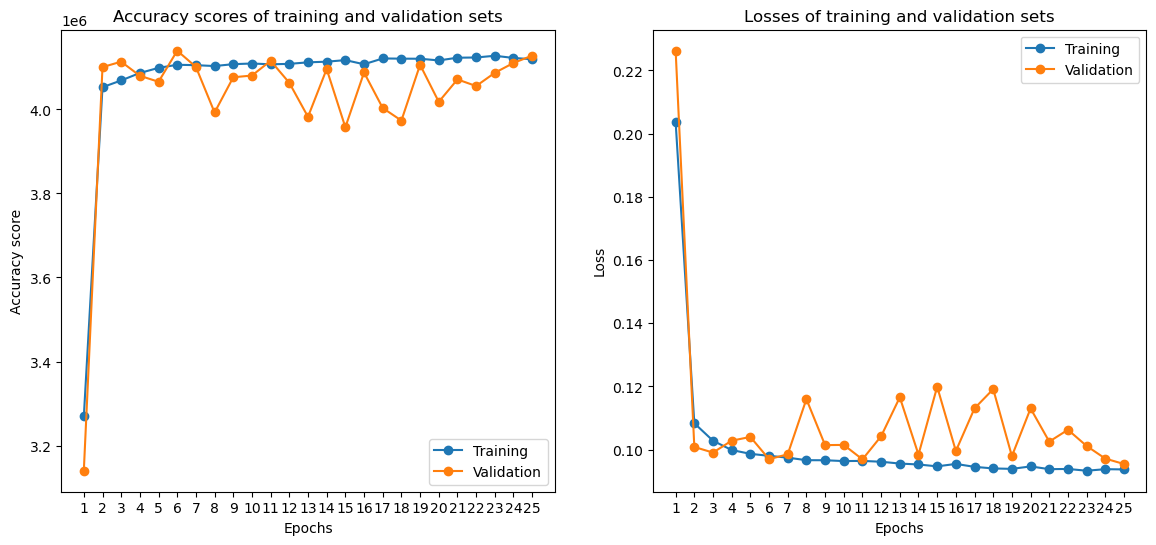

In [114]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
num_epochs = 25

ax1.plot(range(1, num_epochs + 1), train_accs_EOCNet, label="Training", marker='o')
ax1.plot(range(1, num_epochs + 1), valid_accs_EOCNet, label="Validation", marker='o')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy score")
ax1.set_title("Accuracy scores of training and validation sets")
ax1.set_xticks(range(1, num_epochs + 1))
ax1.legend()

ax2.plot(range(1, num_epochs + 1), train_loss_EOCNet, label="Training", marker='o')
ax2.plot(range(1, num_epochs + 1), valid_loss_EOCNet, label="Validation", marker='o')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Losses of training and validation sets")
ax2.set_xticks(range(1, num_epochs + 1))
ax2.legend()
plt.show()


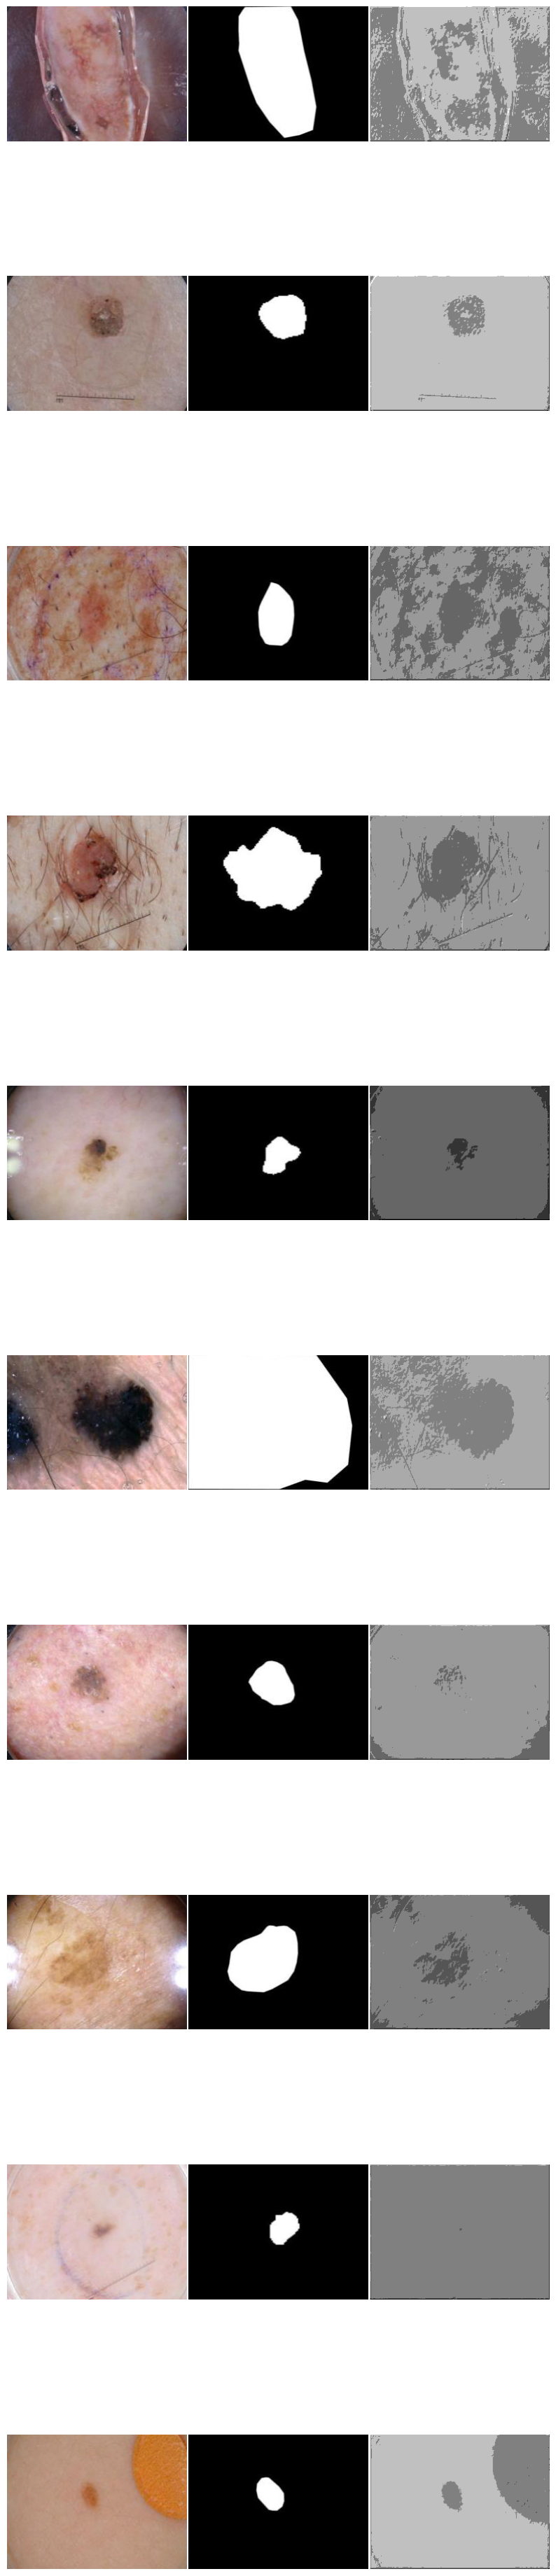

In [27]:
import matplotlib.pyplot as plt
plt.rcParams["grid.linewidth"] = 0
model.eval()
with torch.no_grad():
    for data, target in validation_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        break
num_samples = min(32, data.shape[0])
fig, axs = plt.subplots(num_samples, 3, figsize=(10, 50))
fig.subplots_adjust(hspace=0.01, wspace=0.01)  

for i in range(num_samples):
    axs[i, 0].imshow(TF.to_pil_image(data[i].cpu()))
    axs[i, 1].imshow(TF.to_pil_image(target[i].cpu()), cmap='gray')
    axs[i, 2].imshow(TF.to_pil_image(output[i].cpu()), cmap='gray')
for ax in axs.flatten():
    ax.axis('off')
plt.show()

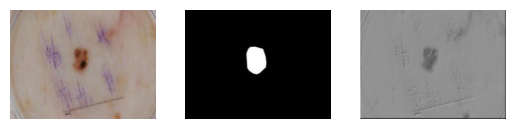

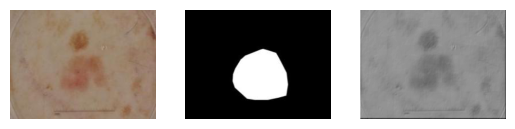

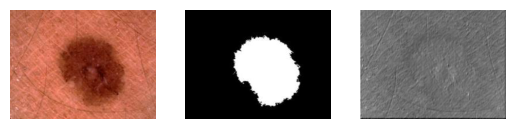

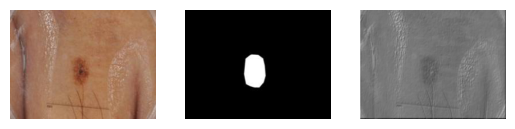

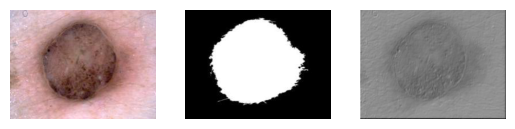

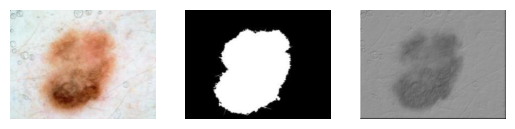

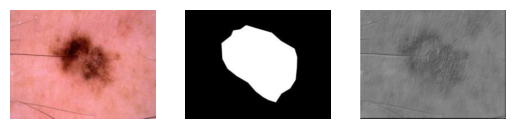

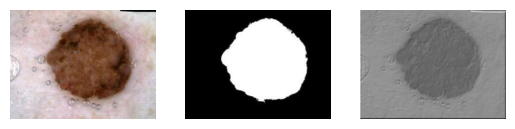

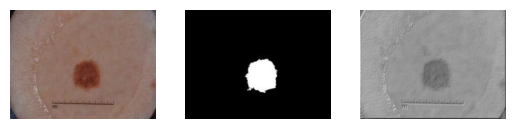

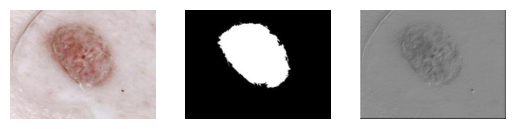

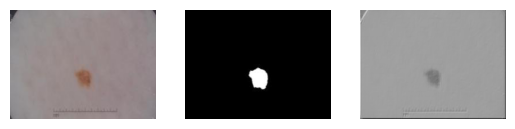

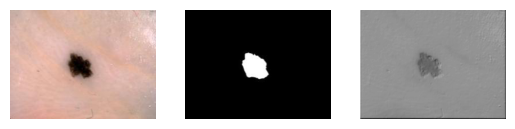

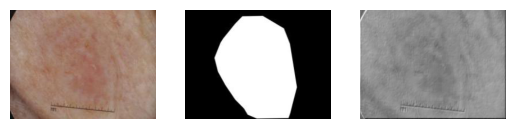

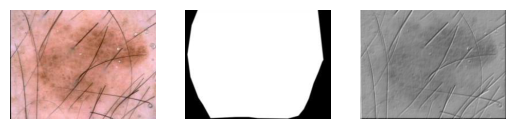

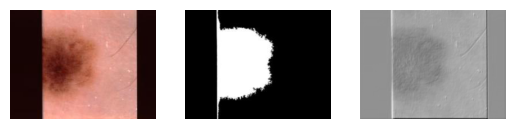

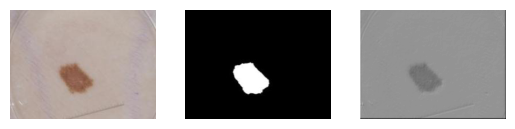

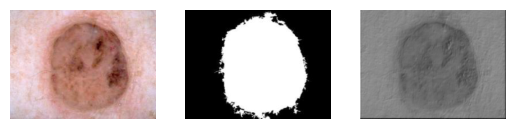

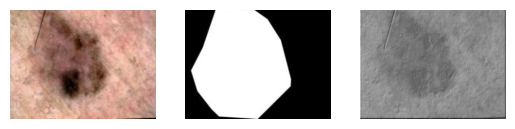

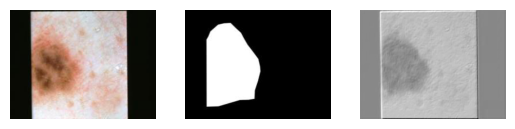

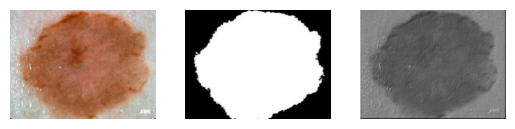

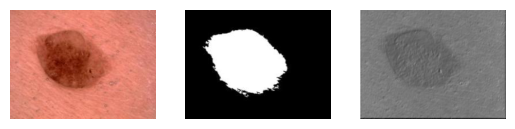

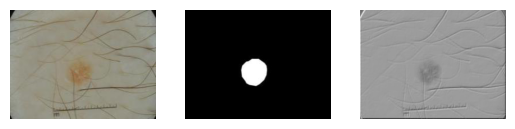

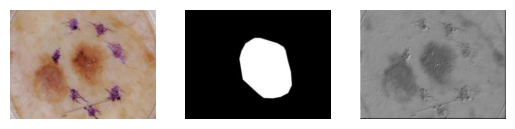

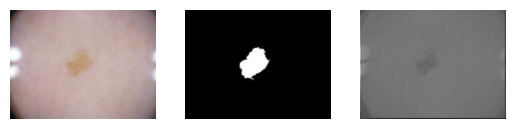

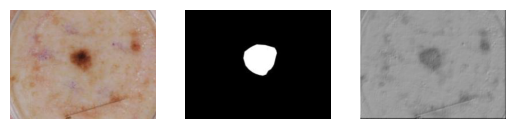

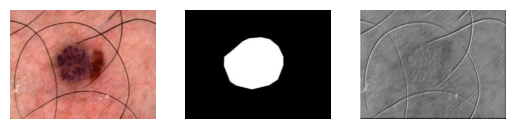

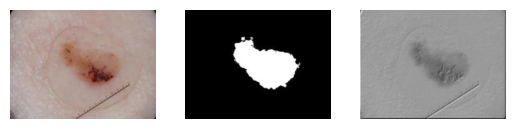

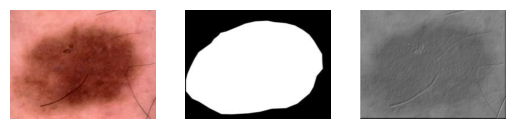

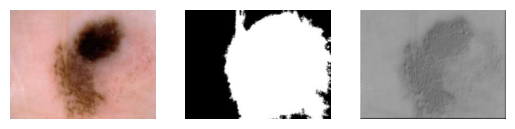

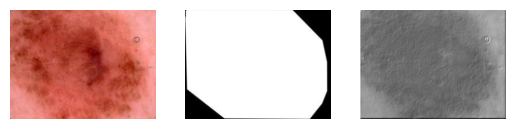

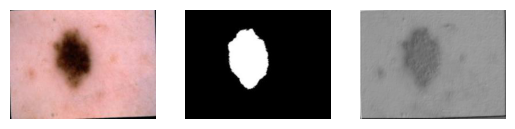

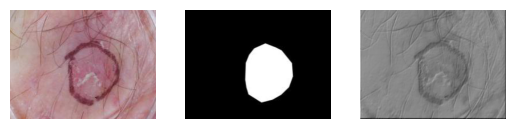

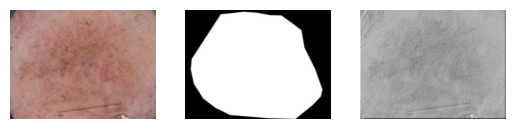

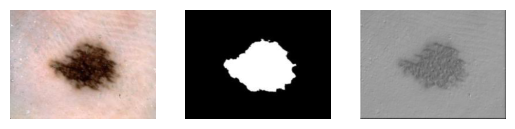

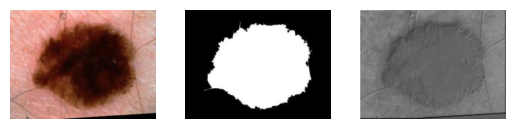

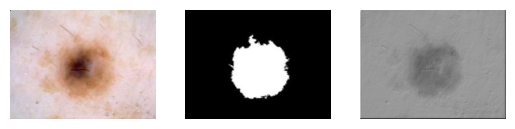

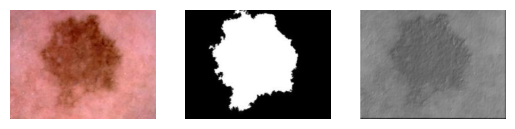

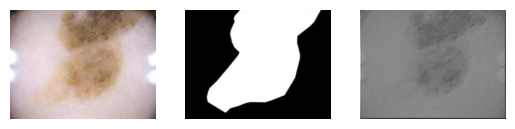

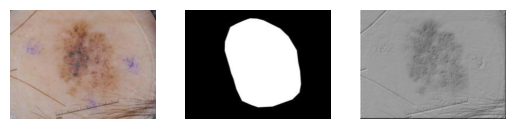

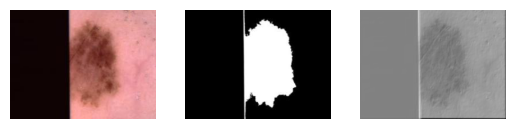

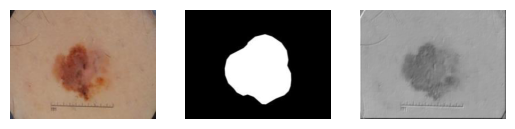

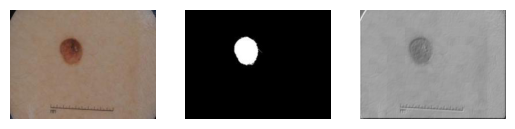

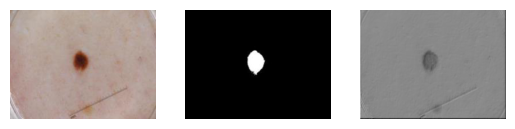

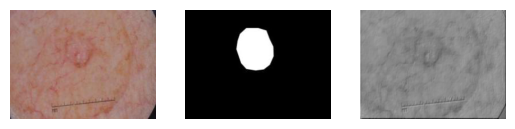

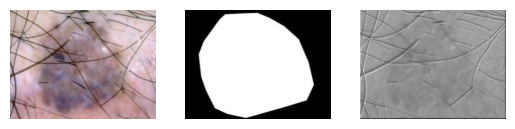

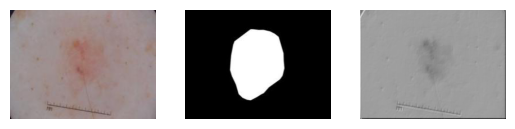

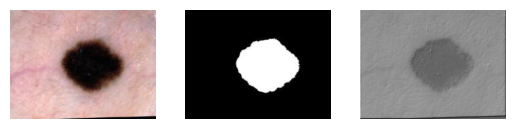

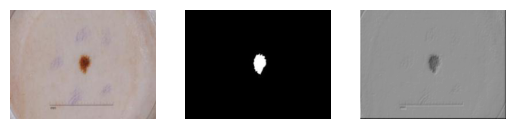

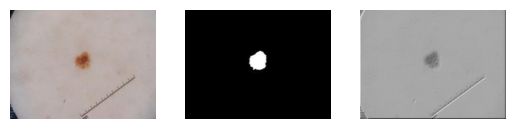

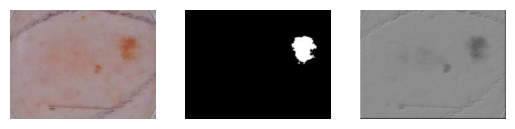

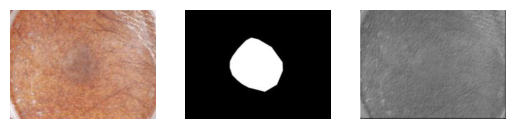

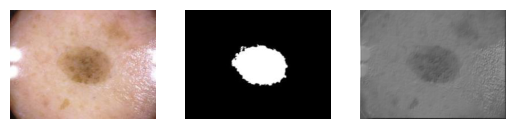

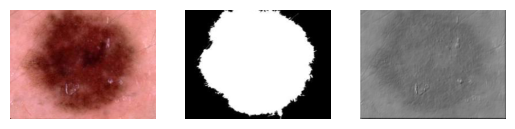

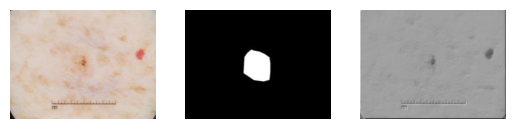

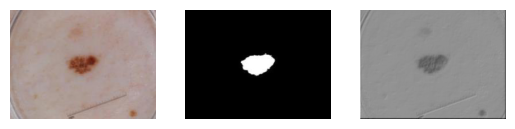

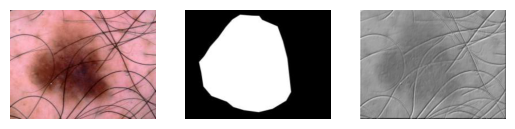

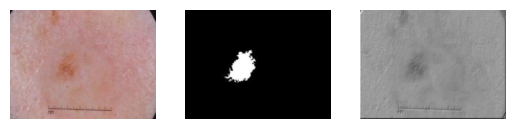

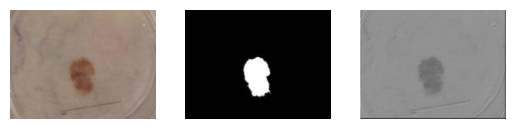

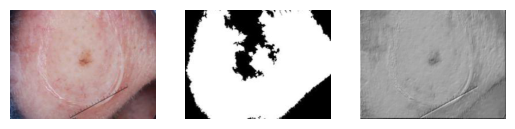

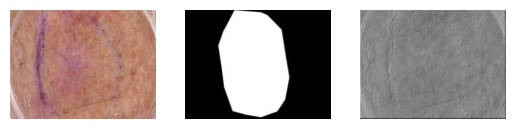

In [28]:
model = model.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
        outputs = outputs
        fig, axs = plt.subplots(1,3)
        axs[0].imshow(inputs[0].permute(1,2,0).cpu().numpy())
        axs[1].imshow(np.squeeze(labels[0].cpu().numpy()), cmap='gray')
        axs[2].imshow(outputs[0].permute(1,2,0).cpu().numpy(),cmap='gray')
        for ax in axs.flatten():
            ax.axis('off')
        plt.show()

In [29]:
model = EOCNet().to(device)
model.load_state_dict(torch.load('EOCNet.pth'))

<All keys matched successfully>

In [30]:
def calculate_metrics(output, target):
    with torch.no_grad():
        output = output.squeeze().round()
        target = target.squeeze()
        TP = ((output == 1) & (target == 1)).sum().float()
        TN = ((output == 0) & (target == 0)).sum().float()
        FP = ((output == 1) & (target == 0)).sum().float()
        FN = ((output == 0) & (target == 1)).sum().float()

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        specificity = TN / (TN + FP)
        dice_coefficient = (2 * TP) / (2 * TP + FP + FN)
        jaccard_similarity = TP / (TP + FP + FN)
        sensitivity = TP / (TP + FN)
        return accuracy.item(), sensitivity.item(), specificity.item(), dice_coefficient.item(), jaccard_similarity.item()


In [45]:
for data, target in validation_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        break
metric_1=calculate_metrics(output, target)

print("Accuracy: ",metric_1[0])
print("Specificity: ",metric_1[1])
print("Dice Coefficient: ",metric_1[2])
print("Jaccard Similarity: ",metric_1[3])
print("Sensitivity: ",metric_1[4])


Accuracy:  0.7670358419418335
Specificity:  0.8495683670043945
Dice Coefficient:  0.5295370221138
Jaccard Similarity:  0.3601158559322357
Sensitivity:  0.5213677883148193


Model-2: UNet

In [32]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.mpconv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        return self.conv(torch.cat([x2, x1], dim=1))


In [33]:
model_2= UNet(n_channels=3, n_classes=1).to(device)

In [34]:
def evaluate(model, data_loader, device):
    criterion = nn.BCELoss()
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            acc = torch.sum(torch.round(outputs) == labels).item()
            val_acc += acc
    val_loss /= len(data_loader)
    val_acc = 100.0 * float(val_acc) / (len(data_loader.dataset))
    return val_loss, val_acc

In [35]:
def train(model, train_loader, validation_loader, num_epochs, batch_size, optimizer, device):
    criterion = nn.BCELoss()
    train_losses = []
    train_accs = []
    val_accs = []
    val_losses = []
    time1 = []
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_acc = 0, 0
        print("\nEpoch: ", str(epoch + 1), "/", str(num_epochs))
        with tqdm(total=len(train_loader)) as pbar:
            for i, data in enumerate(train_loader):
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                acc = torch.sum(torch.round(outputs) == labels).item()
                train_acc += acc
                pbar.set_postfix(Loss='{0:.4f}'.format(loss.item()),Accuracy='{0:.4f}'.format(float(train_acc / (batch_size * (i + 1)))))
                pbar.update(1)

        epoch_loss = train_loss / len(train_loader)
        epoch_acc = 100.0 * float(train_acc) / (len(train_loader) * batch_size)
        val_loss, val_acc = evaluate(model, validation_loader, device)
        val_accs.append(val_acc)
        val_losses.append(val_loss)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        end_time = time.time()
        time2 = end_time - start_time
        time1.append(time2)
        print("Train Loss: {0:.4f}, Train Accuracy: {1:.2f}%, Valid Loss: {2:.4f}, Valid Accuracy: {3:.2f}%".format(epoch_loss, epoch_acc, val_loss, val_acc))
    return train_accs, train_losses, val_accs, val_losses

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=3, n_classes=1).to(device) 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
train_accs, train_losses, val_accs, val_losses = train(model, train_loader, validation_loader, 25, 10, optimizer, device)



Epoch:  1 / 25


100%|██████████| 200/200 [00:24<00:00,  8.17it/s, Accuracy=41144.8440, Loss=0.3340]


Train Loss: 0.4482, Train Accuracy: 4114484.40%, Valid Loss: 0.4315, Valid Accuracy: 4071182.00%

Epoch:  2 / 25


100%|██████████| 200/200 [00:23<00:00,  8.38it/s, Accuracy=42430.8515, Loss=0.2579]


Train Loss: 0.2608, Train Accuracy: 4243085.15%, Valid Loss: 0.2657, Valid Accuracy: 4237084.00%

Epoch:  3 / 25


100%|██████████| 200/200 [00:23<00:00,  8.37it/s, Accuracy=43491.4635, Loss=0.1765]


Train Loss: 0.2039, Train Accuracy: 4349146.35%, Valid Loss: 0.2449, Valid Accuracy: 4286600.00%

Epoch:  4 / 25


100%|██████████| 200/200 [00:24<00:00,  8.21it/s, Accuracy=43960.4800, Loss=0.1386]


Train Loss: 0.1750, Train Accuracy: 4396048.00%, Valid Loss: 0.2095, Valid Accuracy: 4362877.33%

Epoch:  5 / 25


100%|██████████| 200/200 [00:24<00:00,  8.25it/s, Accuracy=44154.6515, Loss=0.2033]


Train Loss: 0.1618, Train Accuracy: 4415465.15%, Valid Loss: 0.2008, Valid Accuracy: 4360541.33%

Epoch:  6 / 25


100%|██████████| 200/200 [00:24<00:00,  8.26it/s, Accuracy=44290.9380, Loss=0.1187]


Train Loss: 0.1520, Train Accuracy: 4429093.80%, Valid Loss: 0.2069, Valid Accuracy: 4370784.67%

Epoch:  7 / 25


100%|██████████| 200/200 [00:24<00:00,  8.33it/s, Accuracy=44443.3695, Loss=0.1653]


Train Loss: 0.1420, Train Accuracy: 4444336.95%, Valid Loss: 0.2192, Valid Accuracy: 4335164.67%

Epoch:  8 / 25


100%|██████████| 200/200 [00:24<00:00,  8.31it/s, Accuracy=44502.8985, Loss=0.1314]


Train Loss: 0.1379, Train Accuracy: 4450289.85%, Valid Loss: 0.2282, Valid Accuracy: 4345353.33%

Epoch:  9 / 25


100%|██████████| 200/200 [00:24<00:00,  8.31it/s, Accuracy=44464.8345, Loss=0.1613]


Train Loss: 0.1374, Train Accuracy: 4446483.45%, Valid Loss: 0.1967, Valid Accuracy: 4366228.67%

Epoch:  10 / 25


100%|██████████| 200/200 [00:23<00:00,  8.34it/s, Accuracy=44607.5555, Loss=0.1220]


Train Loss: 0.1286, Train Accuracy: 4460755.55%, Valid Loss: 0.1969, Valid Accuracy: 4385031.33%

Epoch:  11 / 25


100%|██████████| 200/200 [00:24<00:00,  8.31it/s, Accuracy=44639.3475, Loss=0.1041]


Train Loss: 0.1270, Train Accuracy: 4463934.75%, Valid Loss: 0.1928, Valid Accuracy: 4406240.00%

Epoch:  12 / 25


100%|██████████| 200/200 [00:23<00:00,  8.36it/s, Accuracy=44692.1620, Loss=0.0952]


Train Loss: 0.1251, Train Accuracy: 4469216.20%, Valid Loss: 0.1897, Valid Accuracy: 4382648.00%

Epoch:  13 / 25


100%|██████████| 200/200 [00:23<00:00,  8.38it/s, Accuracy=44734.5285, Loss=0.0603]


Train Loss: 0.1228, Train Accuracy: 4473452.85%, Valid Loss: 0.1934, Valid Accuracy: 4398498.67%

Epoch:  14 / 25


100%|██████████| 200/200 [00:23<00:00,  8.36it/s, Accuracy=44742.8955, Loss=0.1937]


Train Loss: 0.1213, Train Accuracy: 4474289.55%, Valid Loss: 0.1991, Valid Accuracy: 4362044.00%

Epoch:  15 / 25


100%|██████████| 200/200 [00:23<00:00,  8.39it/s, Accuracy=44827.4775, Loss=0.1399]


Train Loss: 0.1157, Train Accuracy: 4482747.75%, Valid Loss: 0.1876, Valid Accuracy: 4397287.33%

Epoch:  16 / 25


100%|██████████| 200/200 [00:23<00:00,  8.40it/s, Accuracy=44881.2760, Loss=0.1980]


Train Loss: 0.1122, Train Accuracy: 4488127.60%, Valid Loss: 0.1879, Valid Accuracy: 4402227.33%

Epoch:  17 / 25


100%|██████████| 200/200 [00:23<00:00,  8.41it/s, Accuracy=44837.9805, Loss=0.0640]


Train Loss: 0.1142, Train Accuracy: 4483798.05%, Valid Loss: 0.2029, Valid Accuracy: 4385338.00%

Epoch:  18 / 25


100%|██████████| 200/200 [00:23<00:00,  8.34it/s, Accuracy=44883.1000, Loss=0.0792]


Train Loss: 0.1114, Train Accuracy: 4488310.00%, Valid Loss: 0.1969, Valid Accuracy: 4395490.00%

Epoch:  19 / 25


100%|██████████| 200/200 [00:23<00:00,  8.35it/s, Accuracy=44982.5230, Loss=0.1041]


Train Loss: 0.1048, Train Accuracy: 4498252.30%, Valid Loss: 0.2057, Valid Accuracy: 4402978.00%

Epoch:  20 / 25


100%|██████████| 200/200 [00:23<00:00,  8.39it/s, Accuracy=44921.8010, Loss=0.1568]


Train Loss: 0.1079, Train Accuracy: 4492180.10%, Valid Loss: 0.1940, Valid Accuracy: 4400233.33%

Epoch:  21 / 25


100%|██████████| 200/200 [00:23<00:00,  8.34it/s, Accuracy=44981.9575, Loss=0.0693]


Train Loss: 0.1040, Train Accuracy: 4498195.75%, Valid Loss: 0.2128, Valid Accuracy: 4411410.67%

Epoch:  22 / 25


100%|██████████| 200/200 [00:23<00:00,  8.41it/s, Accuracy=45096.6180, Loss=0.1745]


Train Loss: 0.0985, Train Accuracy: 4509661.80%, Valid Loss: 0.2000, Valid Accuracy: 4389730.67%

Epoch:  23 / 25


100%|██████████| 200/200 [00:23<00:00,  8.38it/s, Accuracy=45042.1695, Loss=0.0589]


Train Loss: 0.1005, Train Accuracy: 4504216.95%, Valid Loss: 0.2416, Valid Accuracy: 4387106.67%

Epoch:  24 / 25


100%|██████████| 200/200 [00:23<00:00,  8.38it/s, Accuracy=45125.3805, Loss=0.1041]


Train Loss: 0.0964, Train Accuracy: 4512538.05%, Valid Loss: 0.1872, Valid Accuracy: 4397900.00%

Epoch:  25 / 25


100%|██████████| 200/200 [00:23<00:00,  8.39it/s, Accuracy=45167.7170, Loss=0.0820]


Train Loss: 0.0945, Train Accuracy: 4516771.70%, Valid Loss: 0.2137, Valid Accuracy: 4400092.67%


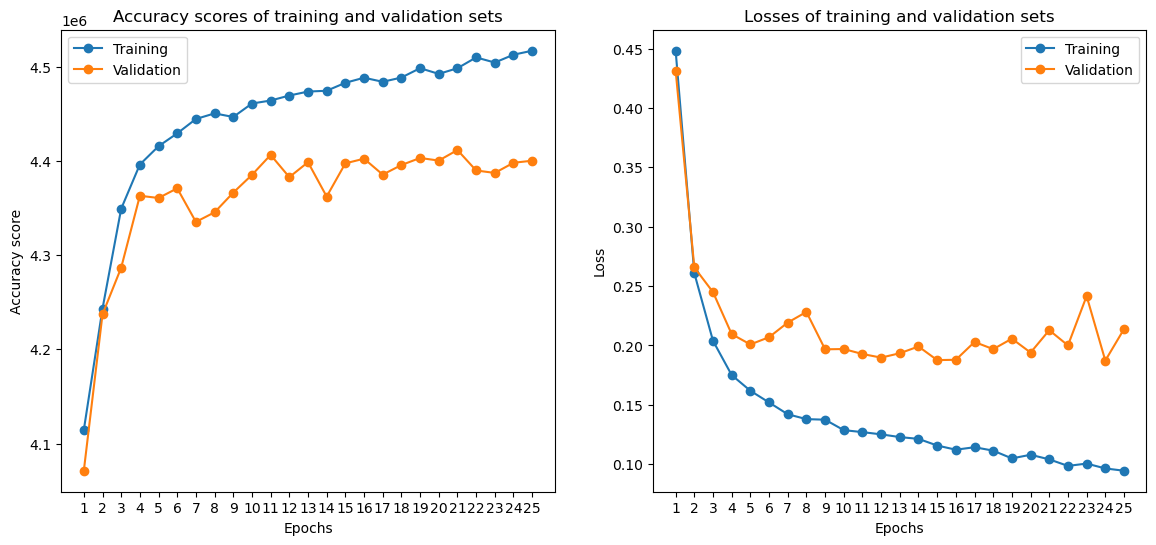

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
num_epochs = 25  

ax1.plot([i + 1 for i in range(num_epochs)], train_accs, label="Training", marker='o')
ax1.plot([i + 1 for i in range(num_epochs)], val_accs, label="Validation", marker='o')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy score")
ax1.set_title("Accuracy scores of training and validation sets")
ax1.set_xticks(ticks=[i + 1 for i in range(num_epochs)])
ax1.set_xticklabels(labels=[i + 1 for i in range(num_epochs)])
ax1.legend()

ax2.plot([i + 1 for i in range(num_epochs)], train_losses, label="Training", marker='o')
ax2.plot([i + 1 for i in range(num_epochs)], val_losses, label="Validation", marker='o')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Losses of training and validation sets")
ax2.set_xticks(ticks=[i + 1 for i in range(num_epochs)])
ax2.set_xticklabels(labels=[i + 1 for i in range(num_epochs)])
ax2.legend()
plt.show()


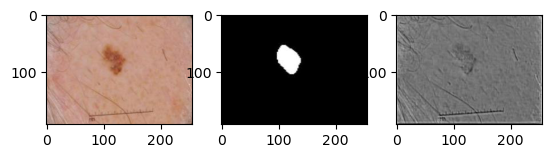

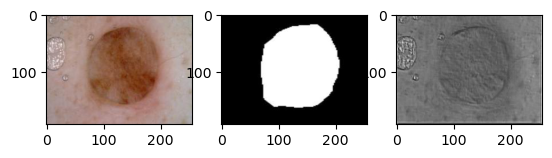

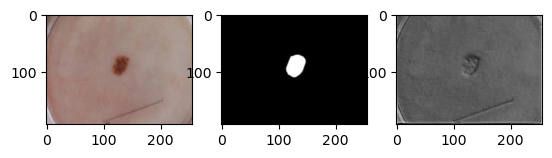

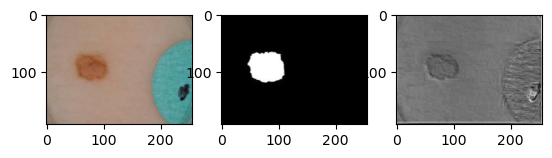

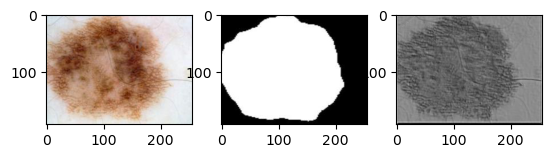

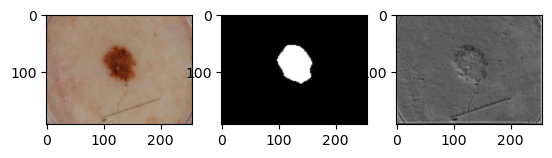

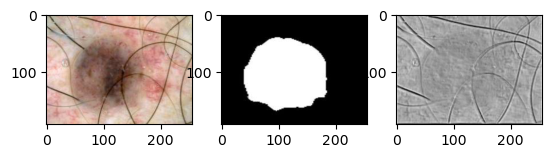

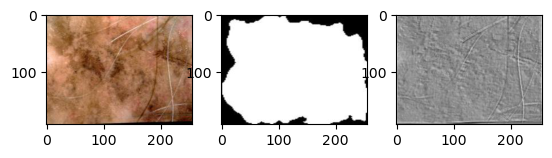

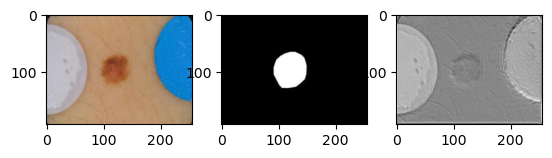

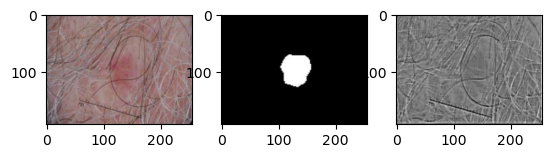

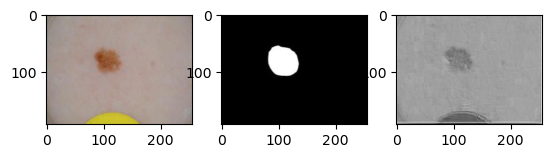

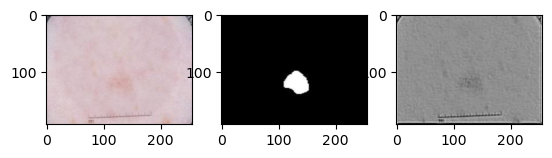

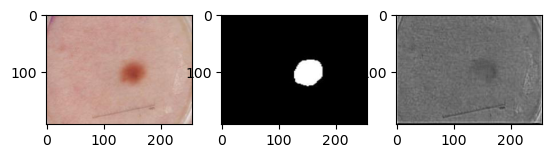

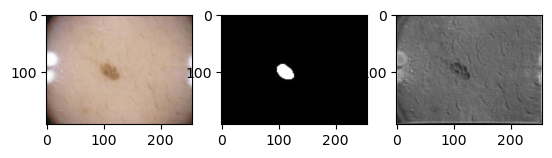

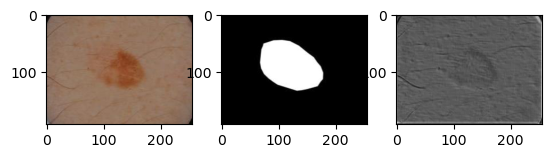

In [38]:
model_2= model_2.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(validation_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_2(inputs)
        outputs = torch.sigmoid(outputs)
        outputs = outputs

        fig, axs = plt.subplots(1,3)
        axs[0].imshow(inputs[0].permute(1,2,0).cpu().numpy())
        axs[1].imshow(np.squeeze(labels[0].cpu().numpy()), cmap='gray')
        axs[2].imshow(outputs[0].permute(1,2,0).cpu().numpy(), cmap='gray')
        plt.show()

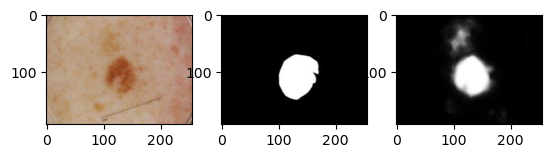

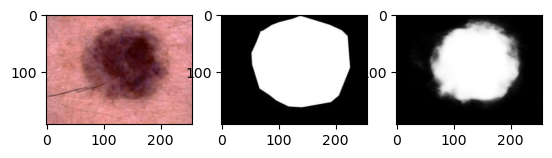

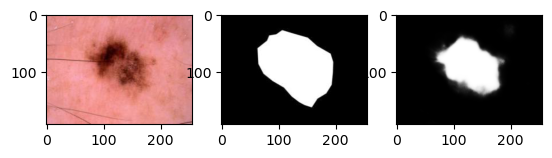

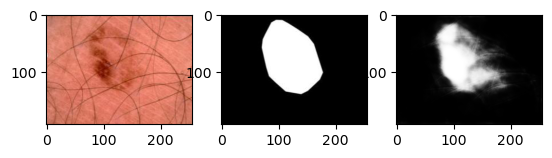

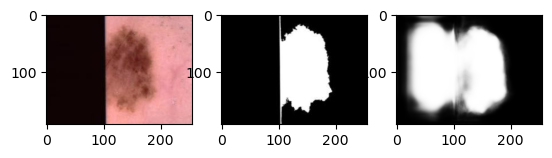

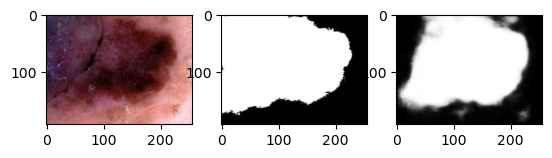

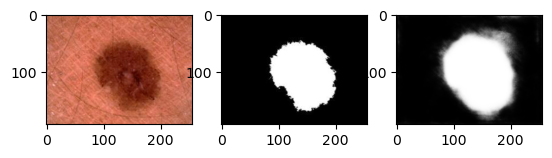

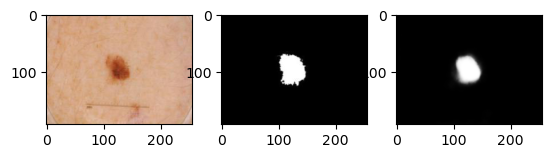

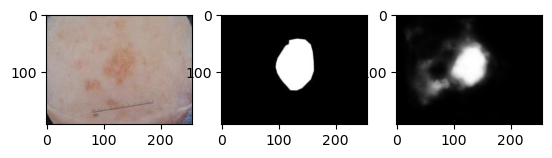

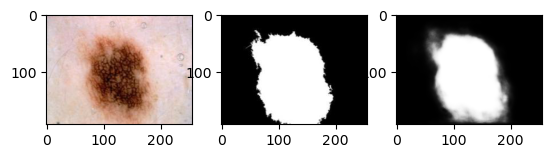

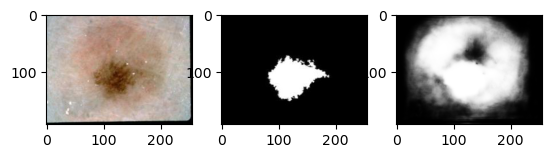

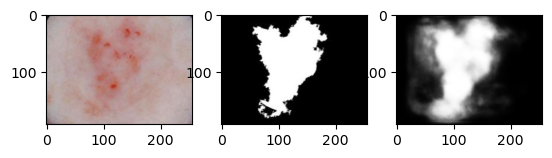

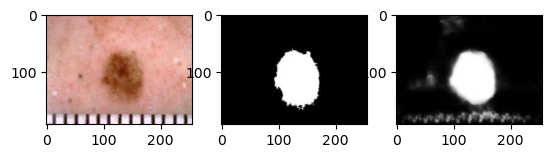

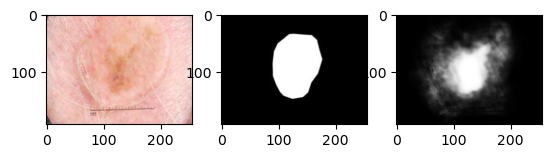

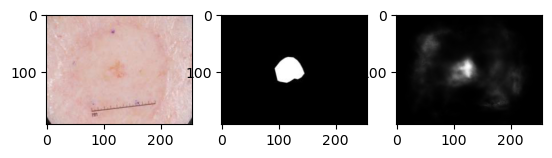

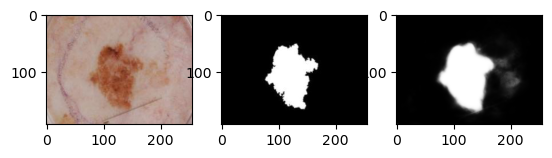

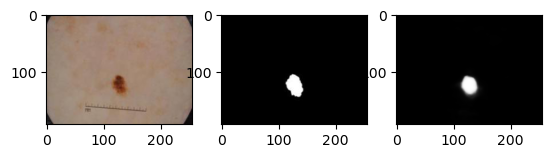

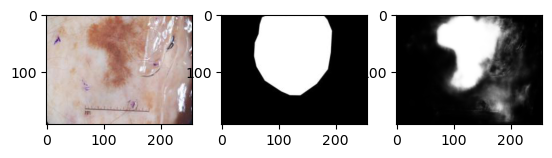

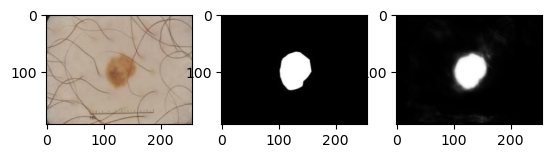

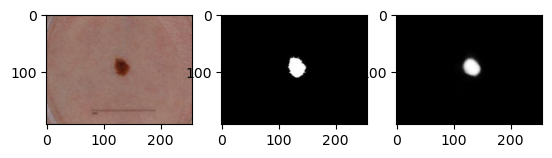

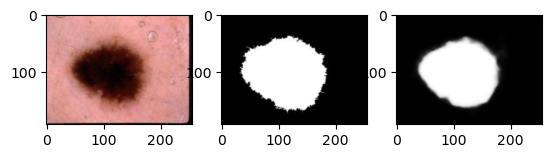

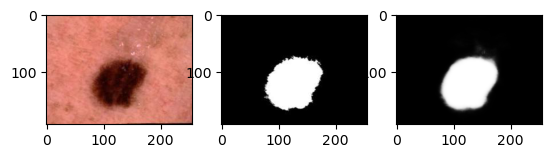

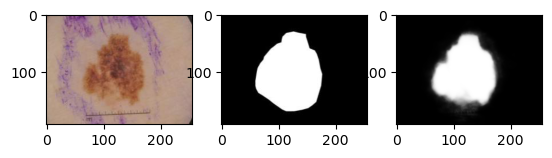

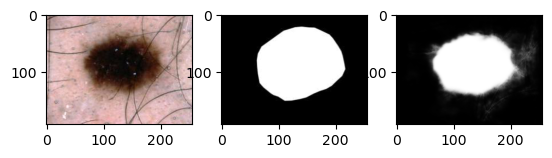

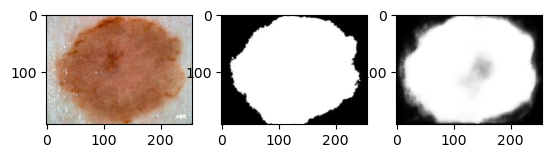

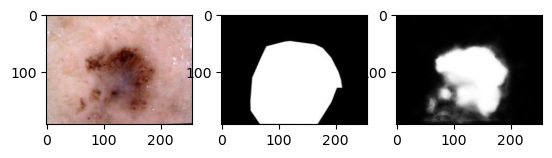

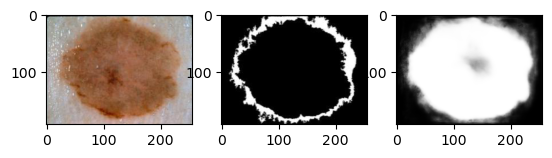

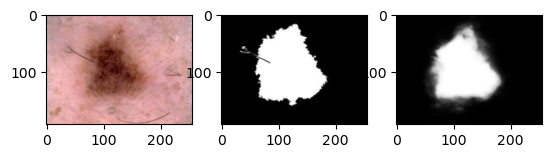

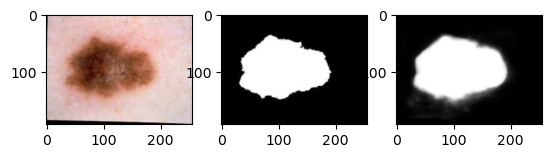

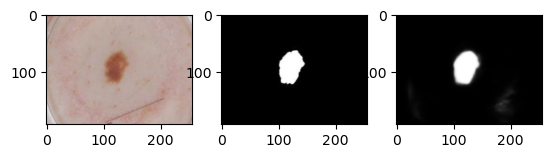

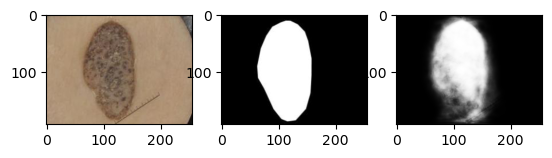

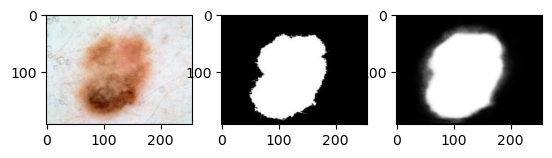

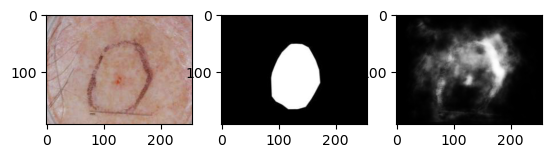

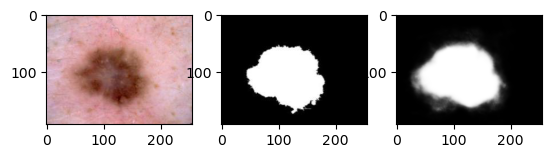

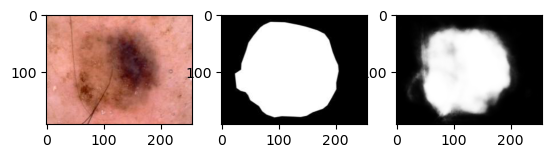

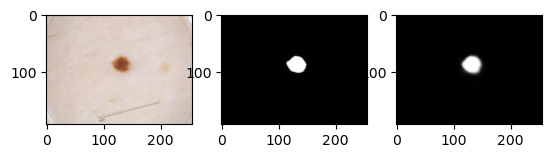

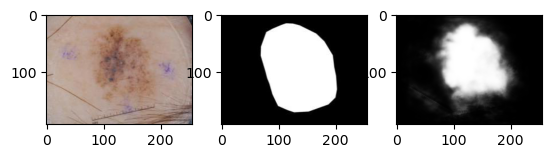

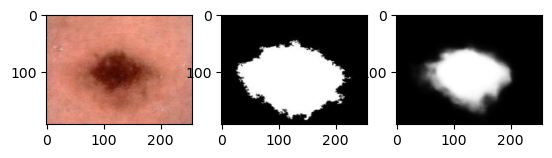

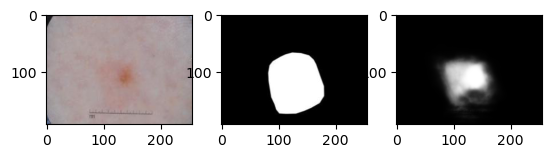

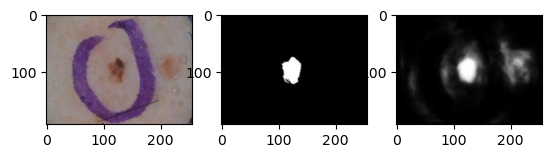

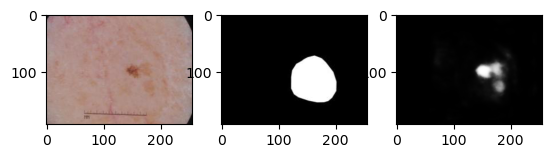

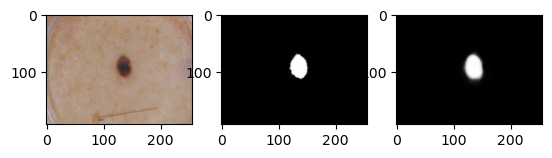

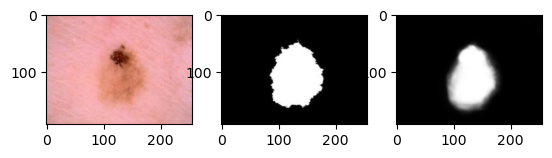

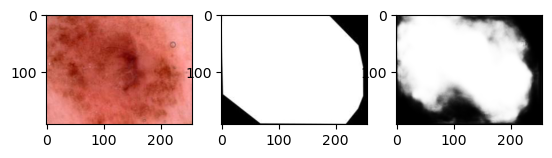

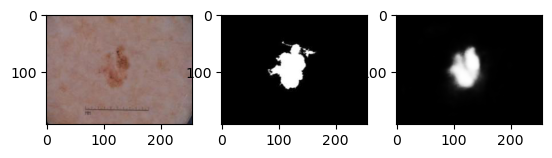

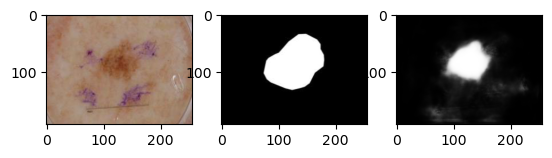

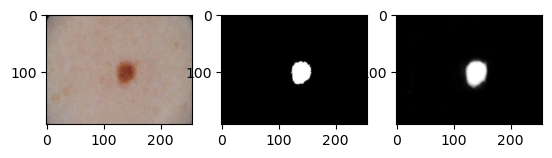

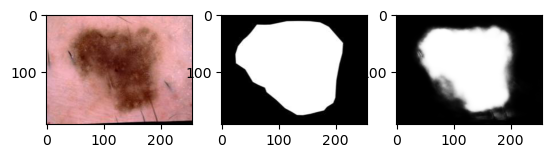

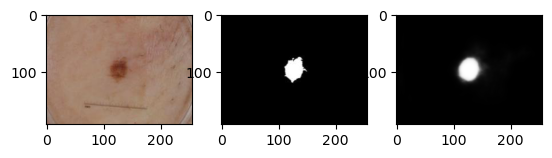

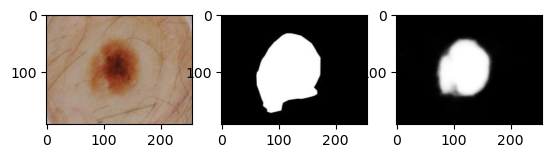

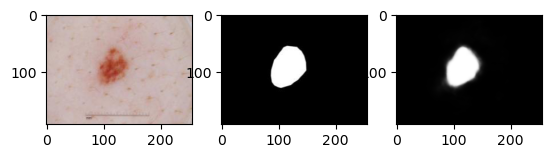

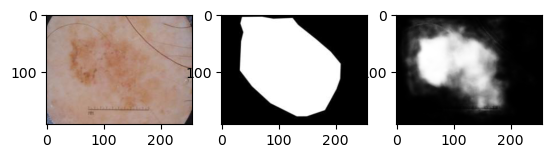

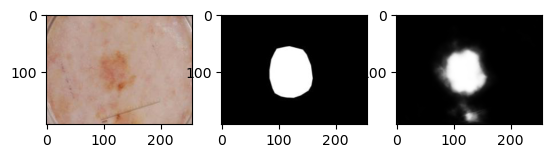

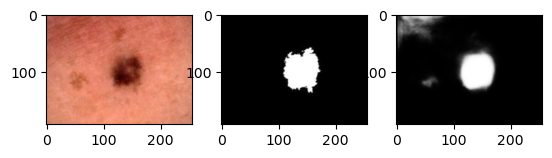

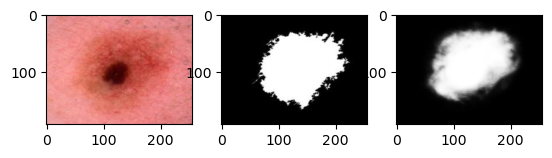

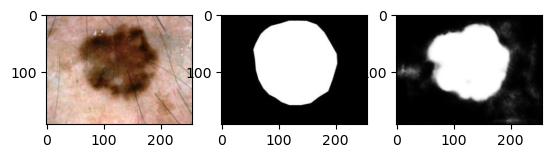

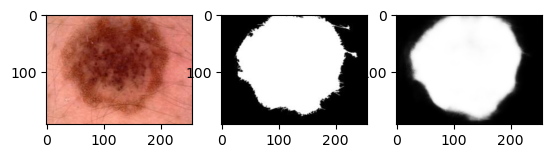

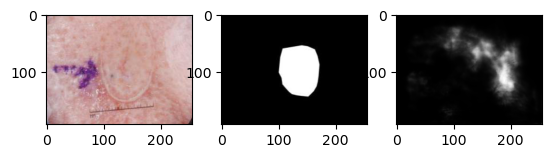

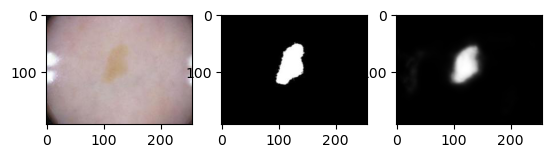

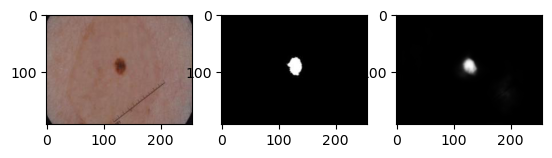

In [41]:
model_2 = model.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_2(inputs)
        outputs = torch.sigmoid(outputs)
        outputs = outputs
        fig, axs = plt.subplots(1,3)
        axs[0].imshow(inputs[0].permute(1,2,0).cpu().numpy())
        axs[1].imshow(np.squeeze(labels[0].cpu().numpy()), cmap='gray')
        axs[2].imshow(outputs[0].permute(1,2,0).cpu().numpy(), cmap='gray')
        plt.show()

In [43]:
for dt, tg in test_loader:
        dt, tg = dt.to(device), tg.to(device)
        result = model_2(dt)
        break

metrics=calculate_metrics(result, tg)

print("Accuracy : ",metrics[0])
print("Specificity : ",metrics[1])
print("Dice Coefficient : ",metrics[2])
print("Jaccard Similarity : ",metrics[3])
print("Sensitivity : ",metrics[4])

Accuracy :  0.690789520740509
Specificity :  0.7217754530906677
Dice Coefficient :  0.5743997693061829
Jaccard Similarity :  0.4012585997581482
Sensitivity :  0.6456007790565491
